<a href="https://colab.research.google.com/github/Tasenko03/nlp_project/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install joblib

In [2]:
import pandas as pd
import numpy as np
import gdown
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from gensim.models import Word2Vec, FastText

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

#Reading data

In [3]:
url = "https://drive.google.com/drive/folders/138Mv-hhvm2e0tTODEomQiUt8CVBOA1mX?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/project data/ria_news.csv',
 '/content/project data/vk_comments.tsv',
 '/content/project data/vk_news.tsv']

In [4]:
ria_news = pd.read_csv('/content/project data/ria_news.csv', sep=';')
ria_news.head()

,href,date,time,title,snippet,category,tags
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,В мире,"Биньямин Нетаньяху, Израиль, В мире"
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...",В мире,"Эммануэль Макрон, Франция, В мире"
2,/20181231/1548961218.html,2018-12-31,"31 декабря 2018, 23:06",СМИ: Кевину Спейси не разрешили отсутствовать ...,Суд в американском штате Массачусетс отверг хо...,В мире,"Кевин Спейси, США, В мире"
3,/20181231/1548961104.html,2018-12-31,"31 декабря 2018, 22:50",В Таиланде россиянин получил тяжелую черепную ...,Россиянин Борис Победоносец 1989 года рождения...,В мире,"Таиланд, В мире"
4,/20181231/1548961026.html,2018-12-31,"31 декабря 2018, 22:33",Медведев поздравил россиян с наступающим Новым...,Глава российского правительства Дмитрий Медвед...,Общество,"Новый год—2019, Дмитрий Медведев, Россия, Обще..."


In [ ]:
print(ria_news.shape)

(153517, 7)


In [9]:
df_vk = pd.read_csv('/content/project data/vk_news.tsv', sep='\t')
print(df_vk.shape)
df_vk.head(3)

(19928, 7)


,id,href,datetime,title,text,likes,comments
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",NaN,15,28
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",NaN,32,42
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",NaN,84,23


#EDA

In [ ]:
ria_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153517 entries, 0 to 153516
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   href      153517 non-null  object
 1   date      153517 non-null  object
 2   time      153517 non-null  object
 3   title     153517 non-null  object
 4   snippet   153517 non-null  object
 5   category  153517 non-null  object
 6   tags      153517 non-null  object
dtypes: object(7)
memory usage: 8.2+ MB


In [ ]:
ria_news.isna().sum()

href        0
date        0
time        0
title       0
snippet     0
category    0
tags        0
dtype: int64

В датасете нет пропущенных значений

In [ ]:
duplicateRows = ria_news[ria_news.duplicated()]
duplicateRows

,href,date,time,title,snippet,category,tags


В датасете нет дубликатов, все новости являются уникальными

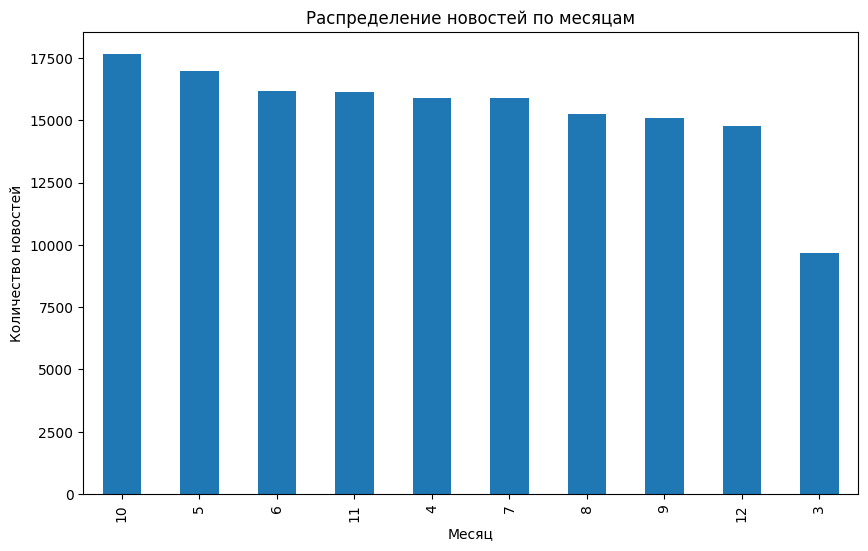

In [ ]:
ria_news["datetime"] = pd.to_datetime(ria_news['date'], format='%Y-%m-%d')

plt.figure(figsize=(10, 6))
ria_news["datetime"].dt.month.value_counts().plot(kind="bar")
plt.title("Распределение новостей по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество новостей")
plt.show()

В общем, данные распределены достаточно равномерно, однако в марте меньше всего данных.

#Preprocessing data

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
stop_words = set(stopwords.words('russian'))

In [7]:
def preprocess_text(text):
    text = re.sub('[^а-яa-z0-9 ]', '', text.lower())
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [10]:
ria_news['title_clean'] = ria_news['title'].apply(preprocess_text)
df_vk['title_clean'] = df_vk.title.apply(preprocess_text)

# Отложенная выборка

In [12]:
ria_hrefs = set(ria_news.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))

df = ria_news[~ria_news.href.isin(test_hrefs)]

Размер отложенной выборки: 1028


In [ ]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = ria_news[ria_news.href.isin(test_hrefs)][['href', 'category']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head(3)

,href,title_clean,category
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,Туризм
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,В мире
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,Наука


# Разбение на обучающую, валидационную и тестовую выборки

In [13]:
x = df['title_clean']
y = df['category']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=77)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.3, random_state=77)

print(f"Training Data Shape: {x_train.shape}")
print(f"Testing Data Shape: {x_test.shape}")
print(f"Validation Data Shape: {x_val.shape}")

Training Data Shape: (106742,)
Testing Data Shape: (32022,)
Validation Data Shape: (13725,)


In [ ]:
ria_news

,href,date,time,title,snippet,category,tags,datetime,title_clean
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,В мире,"Биньямин Нетаньяху, Израиль, В мире",2018-12-31,нетаньяху собирается отставку случае предъявле...
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...",В мире,"Эммануэль Макрон, Франция, В мире",2018-12-31,макрон новогоднем обращении затронул тему реформ
2,/20181231/1548961218.html,2018-12-31,"31 декабря 2018, 23:06",СМИ: Кевину Спейси не разрешили отсутствовать ...,Суд в американском штате Массачусетс отверг хо...,В мире,"Кевин Спейси, США, В мире",2018-12-31,сми кевину спейси разрешили отсутствовать засе...
3,/20181231/1548961104.html,2018-12-31,"31 декабря 2018, 22:50",В Таиланде россиянин получил тяжелую черепную ...,Россиянин Борис Победоносец 1989 года рождения...,В мире,"Таиланд, В мире",2018-12-31,таиланде россиянин получил тяжелую черепную тр...
4,/20181231/1548961026.html,2018-12-31,"31 декабря 2018, 22:33",Медведев поздравил россиян с наступающим Новым...,Глава российского правительства Дмитрий Медвед...,Общество,"Новый год—2019, Дмитрий Медведев, Россия, Обще...",2018-12-31,медведев поздравил россиян наступающим новым г...
...,...,...,...,...,...,...,...,...,...
153512,/20180315/1516435607.html,2018-03-15,"15 марта 2018, 14:49","Во ""Владимирском централе"" убавили громкость п...","<p><strong>ЯРОСЛАВЛЬ, 15 мар — РИА Новости.</...",Происшествия,"Владимир, Владимирская область, Происшествия",2018-03-15,владимирском централе убавили громкость попмузыки
153513,/20180315/1517454702.html,2018-03-15,"15 марта 2018, 14:48","""Газпром"" выделит 22,5 млрд рублей на газопров...","<p><strong>МОСКВА, 15 мар — РИА Новости.</str...",Экономика,"Газпром, Вологодская область, Экономика",2018-03-15,газпром выделит 225 млрд рублей газопроводы во...
153514,/20180315/1516435453.html,2018-03-15,"15 марта 2018, 14:48","Столтенберг проведет встречу с Джонсоном по ""д...","<p><strong>БРЮССЕЛЬ, 15 мар — РИА Новости.</s...",В мире,"Дело об отравлении Скрипалей, НАТО, Великобрит...",2018-03-15,столтенберг проведет встречу джонсоном делу ск...
153515,/20180315/1516435313.html,2018-03-15,"15 марта 2018, 14:47",Британские военные смогут поставить прививку о...,"<p><strong></strong></p>\n<p><strong>ЛОНДОН, ...",В мире,"Великобритания, В мире",2018-03-15,британские военные смогут поставить прививку с...


#Vectorizing

##Word2Vec

In [ ]:
from gensim.models import Word2Vec, FastText
from sklearn.decomposition import PCA

In [ ]:
model_w2v = Word2Vec(sentences=x_train.apply(lambda x: x.split()).tolist(), vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_vector_w2v(sentence):
    vectors = [model_w2v.wv[word] for word in sentence.split() if word in model_w2v.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

x_train_vectors_w2v = np.array(x_train.apply(get_sentence_vector_w2v).tolist())
x_test_vectors_w2v = np.array(x_test.apply(get_sentence_vector_w2v).tolist())

In [ ]:
print("Word2Vec Training Vectors Shape:", x_train_vectors_w2v.shape)
print("Word2Vec Testing Vectors Shape:", x_test_vectors_w2v.shape)

Word2Vec Training Vectors Shape: (106742, 100)
Word2Vec Testing Vectors Shape: (32022, 100)


In [ ]:
x_train_vectors_w2v

array([[-0.20164225,  0.49629965,  0.26648632, ..., -0.5858782 ,
         0.3224001 ,  0.05739506],
       [-0.18799703,  0.36633366,  0.22951181, ..., -1.7547724 ,
        -0.32348564,  0.2871646 ],
       [-0.07673426,  0.54779243,  0.1913425 , ..., -0.5741375 ,
         0.0761596 , -0.00857787],
       ...,
       [-0.22428207,  0.5077945 ,  0.2586402 , ..., -0.7087969 ,
         0.18644938,  0.11066359],
       [-0.2026139 ,  0.3087913 ,  0.27386826, ..., -0.58759815,
        -0.02021147,  0.24261865],
       [-0.3886544 ,  0.46985108,  0.18871315, ..., -0.6053004 ,
        -0.0596329 ,  0.17968892]], dtype=float32)

In [ ]:
x_test_vectors_w2v

array([[ 0.04086751,  0.31875613,  0.18713318, ..., -0.83134305,
         0.32081071, -0.10378819],
       [-0.51478422,  0.8421163 ,  0.26688981, ..., -1.08830726,
        -0.09203024,  0.30216387],
       [ 0.20778167,  0.39611039,  0.03238657, ..., -0.78749555,
         0.2279537 , -0.56233579],
       ...,
       [-0.24656953,  0.19559847,  0.1667456 , ..., -0.39212593,
        -0.2074606 ,  0.21960039],
       [-0.38475269,  0.86846572,  0.37132439, ..., -0.82688332,
         0.32955235,  0.28722802],
       [-0.16244191,  0.44590661,  0.10597439, ..., -0.45653763,
        -0.02481518,  0.10523833]])

In [ ]:
pca = PCA(n_components=5)
x_train_vectors_w2v_reduced = pca.fit_transform(x_train_vectors_w2v)
x_test_vectors_w2v_reduced = pca.transform(x_test_vectors_w2v)

print("Reduced Word2Vec Training Vectors Shape:", x_train_vectors_w2v_reduced.shape)
print("Reduced Word2Vec Testing Vectors Shape:", x_test_vectors_w2v_reduced.shape)


Reduced Word2Vec Training Vectors Shape: (106742, 5)
Reduced Word2Vec Testing Vectors Shape: (32022, 5)


In [ ]:
x_train_vectors_w2v_reduced

array([[ 0.7417873 ,  1.3943137 , -0.80504596,  0.4115353 , -0.23291773],
       [ 1.3217533 ,  2.877635  ,  2.035489  ,  1.9246274 ,  3.3464675 ],
       [ 0.5895918 , -1.5841892 , -0.27115425, -0.19571535,  0.05451707],
       ...,
       [ 0.46218067,  0.16580874, -0.45100236,  0.25436634, -0.08214305],
       [-0.70594156,  0.13001108, -0.7414922 ,  0.38264498,  0.00351775],
       [-0.14584847, -1.0061092 , -0.6796423 , -0.30949306, -0.3302059 ]],
      dtype=float32)

In [ ]:
x_test_vectors_w2v_reduced

array([[ 1.89670845e+00,  1.33466269e-01,  7.03963488e-02,
        -2.16376584e-01,  6.93600397e-01],
       [ 4.40332370e-01, -6.45520793e-01,  8.74127594e-01,
        -5.58302732e-01, -5.13116672e-01],
       [ 2.93934387e+00, -8.70780715e-01,  1.19121924e+00,
        -5.23351804e-01,  2.36495292e+00],
       ...,
       [-1.74033113e+00, -5.32278963e-01, -1.36002903e-01,
         1.50965641e-01, -7.00138302e-04],
       [ 6.39982384e-01, -3.21584552e-01, -7.17618630e-02,
         1.41671980e-01, -2.40868715e-01],
       [-1.73970221e-01, -1.06907227e+00, -2.54949821e-01,
        -3.20775750e-01, -4.16801982e-02]])

##CountVectorizer

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
cv =  CountVectorizer()

X_train_cv = cv.fit_transform(x_train)
X_test_cv = cv.transform(x_test)

#Logistic Regression

In [17]:
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

###Classification with Word2Vec (w/o PCA)

In [ ]:
classifier = LogisticRegression(max_iter=10000)

In [ ]:
classifier.fit(x_train_vectors_w2v, y_train)

y_pred = classifier.predict(x_test_vectors_w2v)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6522390856286303


In [ ]:
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

[[8953   13   33  319  196  584    2  219    7  276]
 [ 247   39    9  271   14   45    0  160    2   36]
 [ 296    2  299  189    3   48    0   59    2   66]
 [1095   19   24 1479  113  357    1  228    5  201]
 [ 832    2    4  196  510   25    0   35    1   72]
 [ 722    2    8  218    6 2692    0   50    2   36]
 [ 312    4    3  100    5   14   65   23    0   17]
 [ 361   11   17  133   15   46    0 5963    4   56]
 [ 262    6   24  152    0   43    1   94   32   55]
 [1142   10   16  502   73   62    0  216    5  854]]
              precision    recall  f1-score   support

      В мире       0.63      0.84      0.72     10602
    Культура       0.36      0.05      0.08       823
       Наука       0.68      0.31      0.43       964
    Общество       0.42      0.42      0.42      3522
    Политика       0.55      0.30      0.39      1677
Происшествия       0.69      0.72      0.70      3736
     Религия       0.94      0.12      0.21       543
       Спорт       0.85      0.90   

###Classification with Word2Vec (with PCA)

In [ ]:
classifier = LogisticRegression(max_iter=10000)

In [ ]:
classifier.fit(x_train_vectors_w2v_reduced, y_train)

y_pred = classifier.predict(x_test_vectors_w2v_reduced)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5682343388920117


In [ ]:
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

[[8796    0    0  254  281  946    0  291    0   34]
 [ 338    0    0  169   12   78    0  222    0    4]
 [ 688    0    0  119    2   67    0   86    0    2]
 [1985    0    0  560  128  540    0  296    0   13]
 [1068    0    0  221  296   29    0   43    0   20]
 [ 958    0    0  139    1 2577    0   61    0    0]
 [ 338    0    0  121    5   35    0   40    0    4]
 [ 455    0    0   86   12   76    0 5958    0   19]
 [ 412    0    0   67    2   65    0  121    0    2]
 [2017    0    0  409   83   95    0  267    0    9]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      В мире       0.52      0.83      0.64     10602
    Культура       0.00      0.00      0.00       823
       Наука       0.00      0.00      0.00       964
    Общество       0.26      0.16      0.20      3522
    Политика       0.36      0.18      0.24      1677
Происшествия       0.57      0.69      0.63      3736
     Религия       0.00      0.00      0.00       543
       Спорт       0.81      0.90      0.85      6606
      Туризм       0.00      0.00      0.00       669
   Экономика       0.08      0.00      0.01      2880

    accuracy                           0.57     32022
   macro avg       0.26      0.28      0.26     32022
weighted avg       0.46      0.57      0.49     32022

0.5682343388920117


###Classification with CountVectorizer (w/o PCA)

In [ ]:
classifier = LogisticRegression(max_iter=10000, random_state=77)

In [ ]:
classifier.fit(X_train_cv, y_train)

y_pred = classifier.predict(X_test_cv)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8451064892886141


In [ ]:
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

[[9836   25   14  129  209  104   14   37   31  203]
 [  96  539    4  120    4   18    3   23    1   15]
 [  81    3  747   70    8   11    0   12    3   29]
 [ 255   53   14 2492  130  277    3   78   36  184]
 [ 407    5    2  188  986   18    1    6    2   62]
 [ 168    8    7  233    9 3263    4   12    7   25]
 [  88   11    2   34    3   10  381    7    3    4]
 [ 114    7    1   79    6   25    0 6354    3   17]
 [ 126   10   10   82    2   17    0   14  379   29]
 [ 361    3    6  303   53   26    0   29   14 2085]]
              precision    recall  f1-score   support

      В мире       0.85      0.93      0.89     10602
    Культура       0.81      0.65      0.72       823
       Наука       0.93      0.77      0.84       964
    Общество       0.67      0.71      0.69      3522
    Политика       0.70      0.59      0.64      1677
Происшествия       0.87      0.87      0.87      3736
     Религия       0.94      0.70      0.80       543
       Спорт       0.97      0.96   

**Word2Vec без PCA**

Модель показала среднюю точность (0.65), с лучшими результатами для "Спорт" и "В мире".

Чуть ниже результаты для "Культура" и "Религия"

**Word2Vec с PCA**

Понижение размерности привело к ухудшению результатов (0.57), особенно для категорий с малым количеством данных, таких как "Культура", "Наука", "Религия" и "Туризм".
PCA может терять важную информацию, особенно если исходные векторы уже имеют низкую размерность.

**CountVectorizer без PCA**

Модель показала наилучшие результаты (0.85) среди всех методов, с высокими показателями для всех категорий.
Этот метод лучше справляется с данной задачей, возможно, из-за большей сохраненной информации в векторах.

#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

###Classification with Word2Vec (w/o PCA)

In [ ]:
rf_w2v = RandomForestClassifier(n_estimators=100, random_state=77)
rf_w2v.fit(x_train_vectors_w2v, y_train)
y_pred_w2v = rf_w2v.predict(x_test_vectors_w2v)

In [ ]:
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
classification_report_w2v = classification_report(y_test, y_pred_w2v)
confusion_matrix_w2v = confusion_matrix(y_test, y_pred_w2v)

In [ ]:
print("Random Forest with Word2Vec without PCA Accuracy:", accuracy_w2v)
print("Classification Report for Random Forest with Word2Vec without PCA")
print(classification_report_w2v)
print("Confusion Matrix for Random Forest with Word2Vec without PCA")
print(confusion_matrix_w2v)

Random Forest with Word2Vec without PCA Accuracy: 0.6608269314846044
Classification Report for Random Forest with Word2Vec without PCA
              precision    recall  f1-score   support

      В мире       0.64      0.85      0.73     10602
    Культура       0.37      0.19      0.25       823
       Наука       0.68      0.32      0.44       964
    Общество       0.43      0.40      0.41      3522
    Политика       0.57      0.33      0.41      1677
Происшествия       0.71      0.73      0.72      3736
     Религия       0.90      0.16      0.27       543
       Спорт       0.87      0.90      0.88      6606
      Туризм       0.40      0.10      0.15       669
   Экономика       0.48      0.30      0.37      2880

    accuracy                           0.66     32022
   macro avg       0.60      0.43      0.46     32022
weighted avg       0.65      0.66      0.64     32022

Confusion Matrix for Random Forest with Word2Vec without PCA
[[9053   54   24  331  172  523    2  185   2

###Classification with Word2Vec (with PCA)

In [ ]:
rf_w2v_pca = RandomForestClassifier(n_estimators=100, random_state=77)
rf_w2v_pca.fit(x_train_vectors_w2v_reduced, y_train)
y_pred_w2v_pca = rf_w2v_pca.predict(x_test_vectors_w2v_reduced)

In [ ]:
accuracy_w2v_pca = accuracy_score(y_test, y_pred_w2v_pca)
classification_report_w2v_pca = classification_report(y_test, y_pred_w2v_pca)
confusion_matrix_w2v_pca = confusion_matrix(y_test, y_pred_w2v_pca)

In [ ]:
print("Random Forest with Word2Vec with PCA Accuracy:", accuracy_w2v_pca)
print("Classification Report for Random Forest with Word2Vec with PCA")
print(classification_report_w2v_pca)
print("Confusion Matrix for Random Forest with Word2Vec with PCA")
print(confusion_matrix_w2v_pca)

Random Forest with Word2Vec with PCA Accuracy: 0.5993379551558303
Classification Report for Random Forest with Word2Vec with PCA
              precision    recall  f1-score   support

      В мире       0.59      0.81      0.68     10602
    Культура       0.27      0.12      0.17       823
       Наука       0.31      0.15      0.20       964
    Общество       0.34      0.29      0.31      3522
    Политика       0.43      0.25      0.31      1677
Происшествия       0.63      0.67      0.65      3736
     Религия       0.75      0.13      0.22       543
       Спорт       0.85      0.89      0.87      6606
      Туризм       0.24      0.05      0.08       669
   Экономика       0.30      0.15      0.20      2880

    accuracy                           0.60     32022
   macro avg       0.47      0.35      0.37     32022
weighted avg       0.56      0.60      0.57     32022

Confusion Matrix for Random Forest with Word2Vec with PCA
[[8590   52   78  437  233  671    4  225   16  296]
 

###Classification with CountVectorizer (w/o PCA)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=77)
rf.fit(X_train_cv, y_train)
y_pred = rf.predict(X_test_cv)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7715945287614765


In [ ]:
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

[[9850   27   21  136   91  272   10   59   16  120]
 [ 217  403    6   96   11   42    2   26    7   13]
 [ 178    4  661   55    6   20    0   12    6   22]
 [ 667   58   23 1834  140  450    6  116   21  207]
 [ 633    4    1  178  738   46    1   22    2   52]
 [ 457   18    8  188   17 2994    6    7    7   34]
 [ 145    8    0   45    2   13  316   10    0    4]
 [ 330    6    1   59   10   60    0 6121    3   16]
 [ 215   13   10   76    3   25    0   26  271   30]
 [ 840    3   13  301   75   82    1   38    7 1520]]
              precision    recall  f1-score   support

      В мире       0.73      0.93      0.82     10602
    Культура       0.74      0.49      0.59       823
       Наука       0.89      0.69      0.77       964
    Общество       0.62      0.52      0.57      3522
    Политика       0.68      0.44      0.53      1677
Происшествия       0.75      0.80      0.77      3736
     Религия       0.92      0.58      0.71       543
       Спорт       0.95      0.93   

**CountVectorizer без PCA**

Модель показала наилучшие результаты (0.77) среди всех методов, с высокими показателями для всех категорий.
Этот метод CountVectorizer лучше справляется с данной задачей



**Random Forest с Word2Vec без PCA**

Модель достигла точности около 66%, что является приемлемым результатом. Однако, оценки precision, recall и f1-score варьируются в зависимости от категории:


*   Наибольшая точность и полнота достигнуты для категорий "Спорт", "Происшествия" и "В мире".

*   Низкая точность и полнота наблюдаются для категорий "Культура", "Религия" и "Туризм". Это может указывать на то, что векторизация Word2Vec без PCA может быть недостаточно информативной для этих категорий из-за недостаточного количества данных или сложности текста в этих категориях.

**Random Forest с Word2Vec с PCA**

После применения PCA точность модели уменьшилась до около 59%. Это может быть связано с тем, что PCA может удалять важные признаки для классификации, особенно если исходные векторы уже имеют низкую размерность.

*   Оценки precision, recall и f1-score также снизились

*  Модель показала наилучшие результаты для категорий "Спорт", "В мире" и "Происшествия", но все еще имеет низкую точность для категорий "Культура", "Религия" и "Туризм".

**Logistic Regression (с CountVectorizer) показала наулучшее качество. Подберем гиперпараметры, чтобы улучшить этот результат**

# **Гиперпараметры**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
X_val_cv = cv.transform(x_val)

In [ ]:
params = {
    "penalty" : ('l1', 'l2'),
    "solver": ("lbfgs", "liblinear", "saga"),
    #"C" : np.logspace(-4, 4, 20)
}

In [ ]:
model = LogisticRegression(max_iter=10000, random_state=77)
clf = GridSearchCV(model, params, cv=3, scoring='accuracy')
best_clf = clf.fit(X_val_cv,y_val)
best_clf.best_estimator_
print(f"Best: score = {best_clf.best_score_}, parametrs = {best_clf.best_params_}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver 

Best: score = 0.7354462659380693, parametrs = {'penalty': 'l2', 'solver': 'liblinear'}


# Модель с лучшими гиперпараметрами

In [18]:
model = LogisticRegression(max_iter=10000, random_state=77, penalty='l2', solver='liblinear')

In [19]:
model.fit(X_train_cv, y_train)
y_pred = model.predict(X_test_cv)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.8480731996752233
[[9941   24   14  107  158  101   13   39   26  179]
 [ 109  537    3  110    3   19    3   23    2   14]
 [  88    3  750   67    6   11    0    9    3   27]
 [ 279   49   17 2465  118  298    3   86   28  179]
 [ 426    5    3  176  980   16    1    9    2   59]
 [ 181    7    5  202   13 3283    5    9    6   25]
 [  98   10    1   41    3    9  370    7    1    3]
 [ 106    6    1   63    7   23    0 6384    2   14]
 [ 136   10   10   83    2   16    0   16  366   30]
 [ 377    3    5  287   54   29    0   32   12 2081]]
              precision    recall  f1-score   support

      В мире       0.85      0.94      0.89     10602
    Культура       0.82      0.65      0.73       823
       Наука       0.93      0.78      0.85       964
    Общество       0.68      0.70      0.69      3522
    Политика       0.73      0.58      0.65      1677
Происшествия       0.86      0.88      0.87      3736
     Религия       0.94      0.68      0.79       543
       

In [22]:
# from sklearn.pipeline import make_pipeline
# pipe = make_pipeline(cv, model)

# pipe.fit(x, y)

# joblib.dump(pipe, 'pipe.joblib')

['pipe.joblib']

# Проверка результата на отложенной выборке

In [ ]:
df_oob.head(3)

,href,title_clean,category
0,/20181206/1547493936.html,эксперты определили самые бюджетные экзотическ...,Туризм
1,/20181206/1547516457.html,рада приняла закон расширяющий контролируемую ...,В мире
2,/20181206/1547520788.html,россия оказалась родиной древнейших титанозавр...,Наука


In [ ]:
x = df_oob['title_clean']
y = df_oob['category']

X_test_vk = cv.transform(x)

In [ ]:
y_pred_vk = model.predict(X_test_vk)
accuracy = accuracy_score(y, y_pred_vk)
print("Accuracy:", accuracy)

print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.7633365664403492
[[9941   24   14  107  158  101   13   39   26  179]
 [ 109  537    3  110    3   19    3   23    2   14]
 [  88    3  750   67    6   11    0    9    3   27]
 [ 279   49   17 2465  118  298    3   86   28  179]
 [ 426    5    3  176  980   16    1    9    2   59]
 [ 181    7    5  202   13 3283    5    9    6   25]
 [  98   10    1   41    3    9  370    7    1    3]
 [ 106    6    1   63    7   23    0 6384    2   14]
 [ 136   10   10   83    2   16    0   16  366   30]
 [ 377    3    5  287   54   29    0   32   12 2081]]
              precision    recall  f1-score   support

      В мире       0.85      0.94      0.89     10602
    Культура       0.82      0.65      0.73       823
       Наука       0.93      0.78      0.85       964
    Общество       0.68      0.70      0.69      3522
    Политика       0.73      0.58      0.65      1677
Происшествия       0.86      0.88      0.87      3736
     Религия       0.94      0.68      0.79       543
       

**Качество на отложенной выборке чуть ниже, но все равно достатчно высокое.**